In [1]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score


# Step 1: Data Preprocessing

In [2]:
# Define your target dataset path
target_dir = '../original_dataset'

# Check if the path exists
if os.path.exists(target_dir):
    print(f"The dataset path {target_dir} exists.")
else:
    print(f"The dataset path {target_dir} does not exist.")

The dataset path ../original_dataset exists.


## Check dataset size 

In [4]:
classes = ['home_office', 'hotel_room', 'church', 'museum', 'supermarket']

def show_target_dir_status(target_dir, classes):
    """
    Show the number of images in each class directory within the target directory.

    """
    print(f"Status of target directory: {target_dir}")
    for cls in classes:
        class_dir = os.path.join(target_dir, cls)
        if os.path.exists(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"Class '{cls}' contains {num_images} images.")
            
        else:
            print(f"Class directory '{cls}' does not exist.")

# Show the status of the target directory
show_target_dir_status(target_dir, classes)

Status of target directory: ../original_dataset
Class 'home_office' contains 1346 images.
Class 'hotel_room' contains 1524 images.
Class 'church' contains 798 images.
Class 'museum' contains 761 images.
Class 'supermarket' contains 1466 images.


## Show images with their corresponded labels 

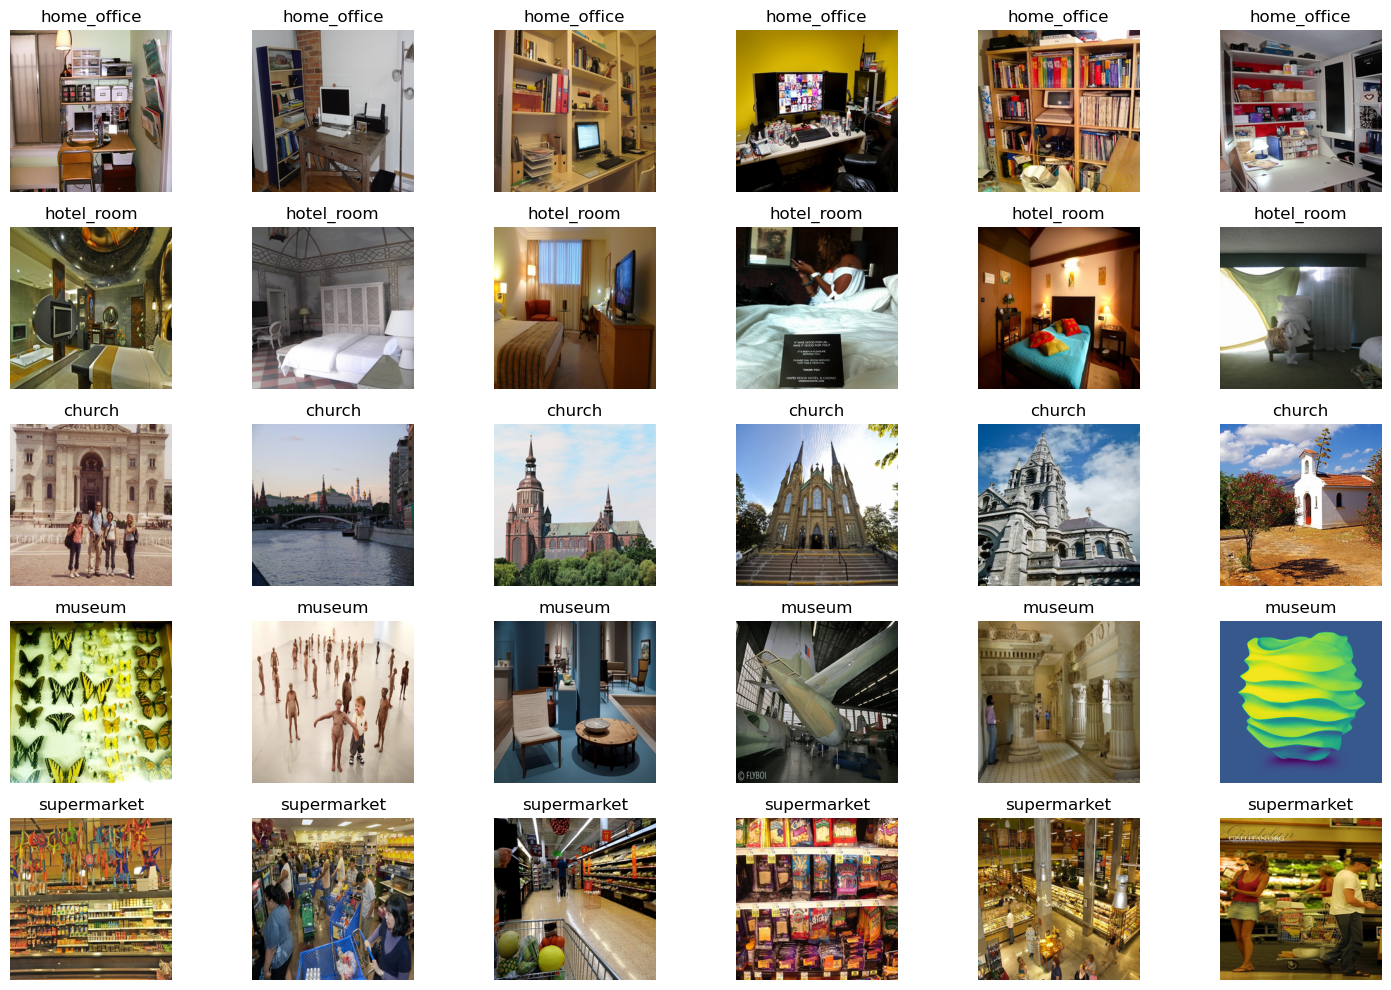

In [5]:
def show_images_with_labels(target_dir, classes, num_images=6):
    """
    Display images with their corresponding labels from the target directory.

    """
    # Create figure and axes
    fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 10))
    
    # Iterate through each class
    for i, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        class_images = os.listdir(class_dir)
        selected_images = np.random.choice(class_images, num_images, replace=False)
        
        # Iterate through selected images for the class
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            
            # Plot the image
            axes[i, j].imshow(img)
            axes[i, j].set_title(cls)
            axes[i, j].axis('off')
    
    # Adjust layout and display the plot
    plt.tight_layout()

show_images_with_labels(target_dir, classes)

In [6]:
# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Parameters
batch_size = 32
image_size = (256, 256)

# Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(root='../original_dataset', transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 2: Define the CNN Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, len(dataset.classes))
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model and move it to the device
model = CNN().to(device)

# Step 3: Training the Model

## Setting hyperparameters and functions for training and validation

In [10]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 10

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy

## Training loop and saving the best model

In [16]:
train_losses = []
val_losses = []
val_accuracies = []
best_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Epoch 1/10, Train Loss: 0.0646, Validation Loss: 2.7874, Validation Accuracy: 0.6124
Epoch 2/10, Train Loss: 0.0221, Validation Loss: 3.1025, Validation Accuracy: 0.6277
Epoch 3/10, Train Loss: 0.0076, Validation Loss: 3.4466, Validation Accuracy: 0.6166
Epoch 4/10, Train Loss: 0.0064, Validation Loss: 3.6710, Validation Accuracy: 0.6141
Epoch 5/10, Train Loss: 0.0054, Validation Loss: 3.5792, Validation Accuracy: 0.6047
Epoch 6/10, Train Loss: 0.0131, Validation Loss: 3.2756, Validation Accuracy: 0.6149
Epoch 7/10, Train Loss: 0.0079, Validation Loss: 3.5783, Validation Accuracy: 0.6141
Epoch 8/10, Train Loss: 0.0089, Validation Loss: 3.4594, Validation Accuracy: 0.6115
Epoch 9/10, Train Loss: 0.0184, Validation Loss: 3.6059, Validation Accuracy: 0.6149
Epoch 10/10, Train Loss: 0.0439, Validation Loss: 3.6378, Validation Accuracy: 0.6175
Best Validation Accuracy: 0.6277


## Plotting training and validation loss

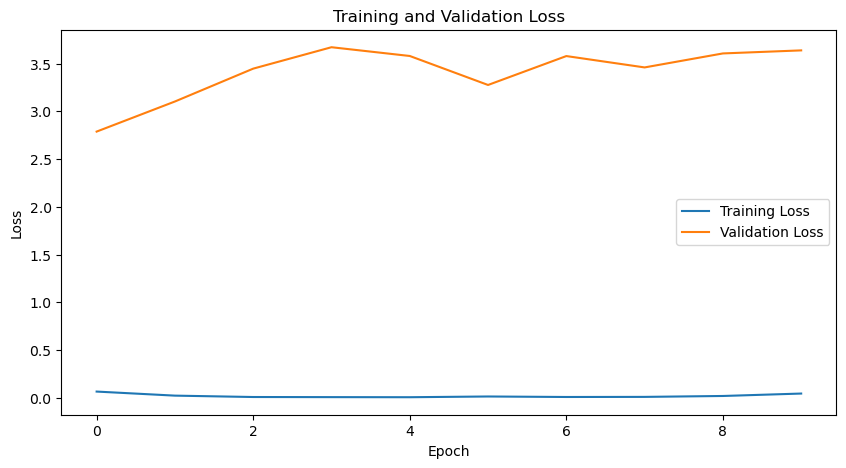

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Plotting validation accuracy

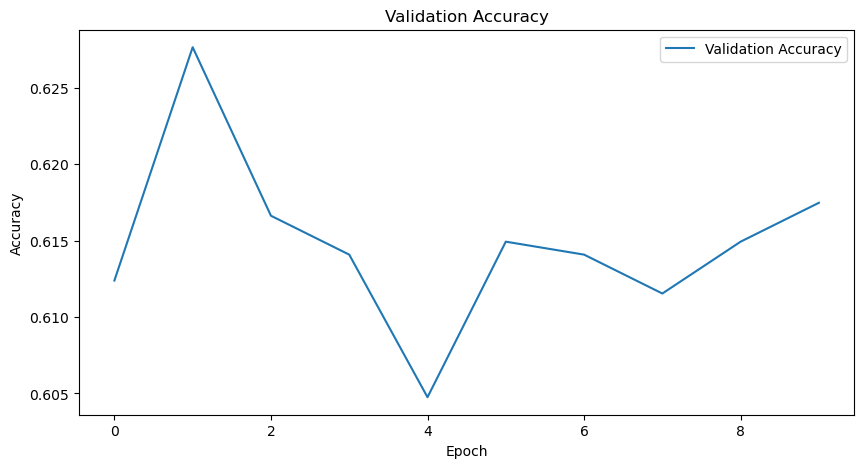

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

# Step 4: Loading the Model and Making Predictions

In [19]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Function to predict on the test set
def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

# Predict on the test set
test_preds = predict(model, test_loader, device)

## Making the prediction

In [20]:
# Function to predict on a single image
def predict_single_image(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).cpu().numpy()[0]
    return dataset.classes[pred]

# Predict on a single image
image_path = '../original_dataset/home_office/gsun_00ba303fa8c4006c1a6fd17f2cc3dff4.jpg'
single_pred = predict_single_image(model, image_path, transform, device)
print(f"Predicted class: {single_pred}")

Predicted class: home_office


# Confusion Matrix

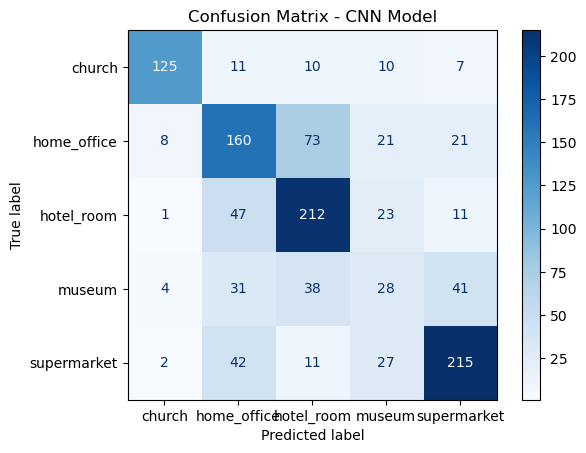

In [21]:
# Generate confusion matrix
y_test_labels = [label for _, label in test_dataset]
cm = confusion_matrix(y_test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CNN Model")
plt.show()

# Evaluate the model

In [22]:
accuracy = accuracy_score(y_test_labels, test_preds)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_labels, test_preds, target_names=classes))

Accuracy: 0.6276505513146734
Classification Report:
               precision    recall  f1-score   support

 home_office       0.89      0.77      0.83       163
  hotel_room       0.55      0.57      0.56       283
      church       0.62      0.72      0.66       294
      museum       0.26      0.20      0.22       142
 supermarket       0.73      0.72      0.73       297

    accuracy                           0.63      1179
   macro avg       0.61      0.59      0.60      1179
weighted avg       0.62      0.63      0.62      1179

